# Implementação de Árvore 2-3-4 (B-Tree Ordem 4)


--- Inserindo Dados ---
Dataset: [10, 20, 30, 40, 50, 60, 20, 20, 10]

--- Visualização Final ---


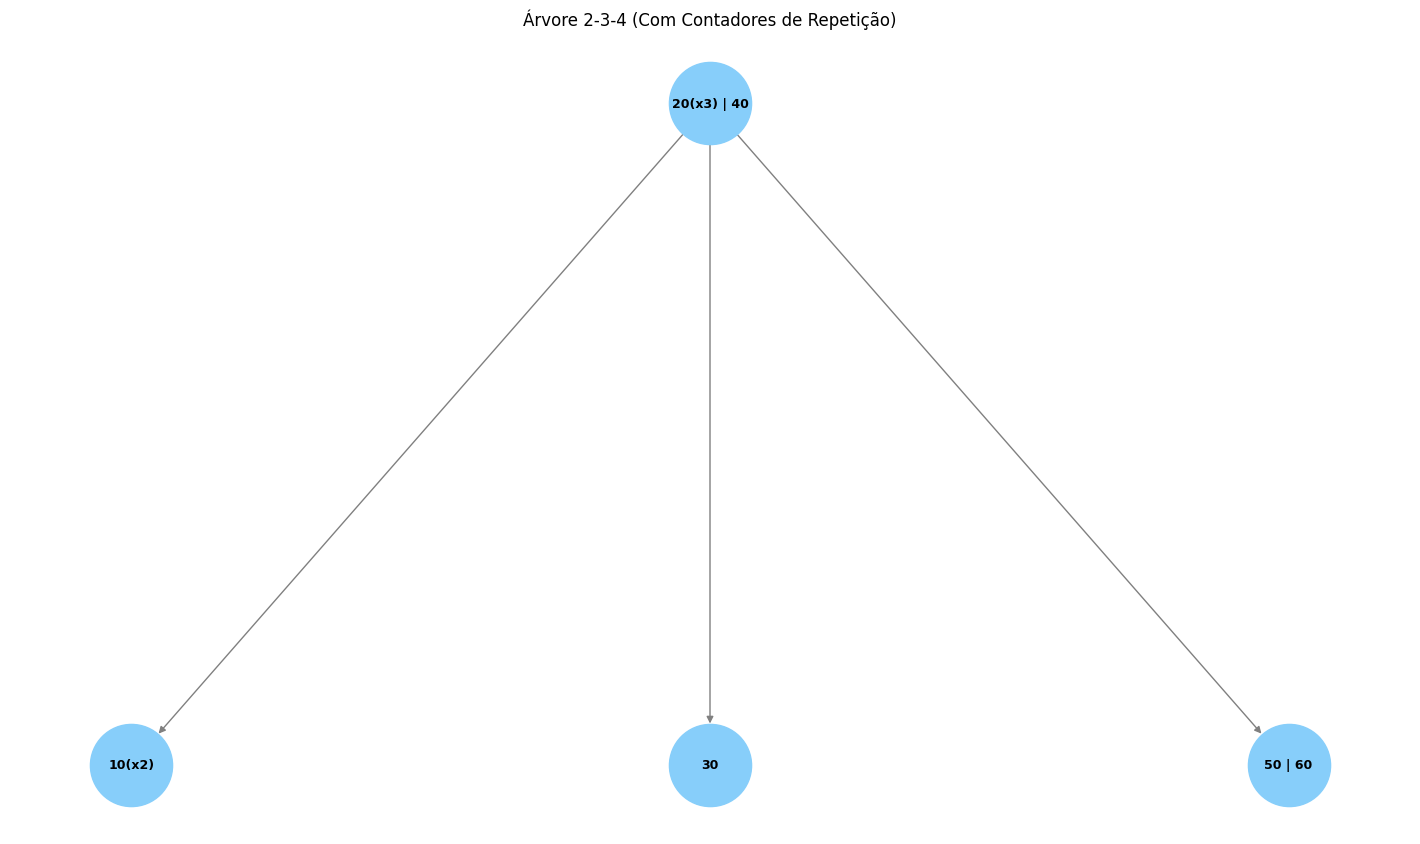

--- Removendo um 20 ---
Chave 20 decrementada. Qtd atual: 2


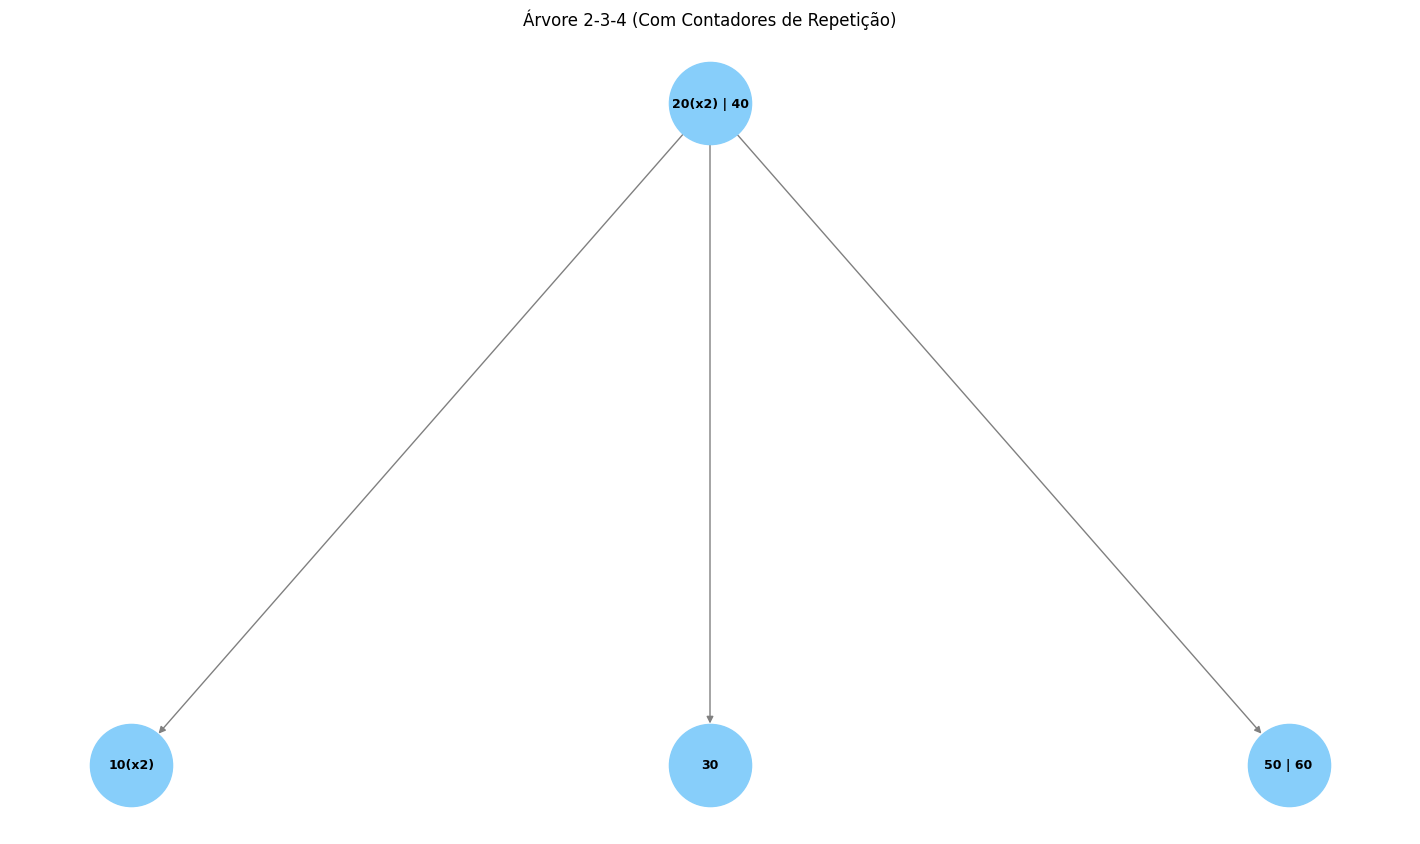

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

class Node:
    def __init__(self, leaf=False):
        self.keys = []
        self.counts = [] # Lista de contadores
        self.children = []
        self.leaf = leaf

    def is_full(self):
        return len(self.keys) == 3

    def __repr__(self):
        return f"[{', '.join(map(str, self.keys))}]"

class Tree234:
    def __init__(self):
        self.root = Node(leaf=True)
        self.t = 2 

    def search(self, k, x=None):
        if x is None:
            x = self.root
        i = 0
        while i < len(x.keys) and k > x.keys[i]:
            i += 1
        if i < len(x.keys) and k == x.keys[i]:
            return (x, i)
        elif x.leaf:
            return None
        else:
            return self.search(k, x.children[i])

    def split_child(self, x, i):
        y = x.children[i]
        z = Node(leaf=y.leaf)
        
        # Mover chave E contador
        z.keys = [y.keys[2]]
        z.counts = [y.counts[2]] 
        
        if not y.leaf:
            z.children = y.children[2:]
            y.children = y.children[:2]
            
        mid_key = y.keys[1]
        mid_count = y.counts[1] 
        
        y.keys = [y.keys[0]]
        y.counts = [y.counts[0]] 
        
        x.children.insert(i + 1, z)
        x.keys.insert(i, mid_key)
        x.counts.insert(i, mid_count) 

    def insert(self, k):
        r = self.root
        if r.is_full():
            s = Node(leaf=False)
            self.root = s
            s.children.append(r)
            self.split_child(s, 0)
            self._insert_non_full(s, k)
        else:
            self._insert_non_full(r, k)

    def _insert_non_full(self, x, k):
        i = len(x.keys) - 1
        
        # Verifica se já existe para incrementar contador
        for idx, key in enumerate(x.keys):
            if key == k:
                x.counts[idx] += 1
                return

        if x.leaf:
            x.keys.append(None)
            x.counts.append(None) # Espaço pro contador
            
            while i >= 0 and k < x.keys[i]:
                x.keys[i + 1] = x.keys[i]
                x.counts[i + 1] = x.counts[i] # Move contador
                i -= 1
            x.keys[i + 1] = k
            x.counts[i + 1] = 1 # Inicia contador com 1
        else:
            while i >= 0 and k < x.keys[i]:
                i -= 1
            i += 1
            if x.children[i].is_full():
                self.split_child(x, i)
                if k > x.keys[i]:
                    i += 1
                elif k == x.keys[i]: # Caso raro no split
                    x.counts[i] += 1
                    return
            self._insert_non_full(x.children[i], k)

    def delete(self, k):
        if not self.root.keys:
            return
        
        # Lógica extra: verificar se é apenas decremento de contador
        found = self.search(k)
        if found:
            node, idx = found
            if node.counts[idx] > 1:
                node.counts[idx] -= 1
                print(f"Chave {k} decrementada. Qtd atual: {node.counts[idx]}")
                return

        # Se contador == 1, faz a remoção estrutural
        self._delete(self.root, k)
        
        if len(self.root.keys) == 0 and not self.root.leaf:
            self.root = self.root.children[0]

    def _delete(self, x, k):
        t = self.t
        i = 0
        while i < len(x.keys) and k > x.keys[i]:
            i += 1
        
        if i < len(x.keys) and k == x.keys[i]:
            if x.leaf:
                x.keys.pop(i)
                x.counts.pop(i) # Remove contador
            else:
                y = x.children[i]
                z = x.children[i+1]
                if len(y.keys) >= t:
                    pred = self._get_pred(y)
                    x.keys[i] = pred
                    x.counts[i] = 1 # Resetamos contador pois trouxemos "um exemplar"
                    self._delete(y, pred)
                elif len(z.keys) >= t:
                    succ = self._get_succ(z)
                    x.keys[i] = succ
                    x.counts[i] = 1
                    self._delete(z, succ)
                else:
                    self._merge(x, i, y, z)
                    self._delete(y, k)
        elif not x.leaf:
            child = x.children[i]
            if len(child.keys) == t - 1:
                left = x.children[i-1] if i > 0 else None
                right = x.children[i+1] if i < len(x.keys) else None
                
                if left and len(left.keys) >= t:
                    child.keys.insert(0, x.keys[i-1])
                    child.counts.insert(0, x.counts[i-1]) # Move count
                    
                    x.keys[i-1] = left.keys.pop()
                    x.counts[i-1] = left.counts.pop() # Move count
                    
                    if not child.leaf:
                        child.children.insert(0, left.children.pop())
                elif right and len(right.keys) >= t:
                    child.keys.append(x.keys[i])
                    child.counts.append(x.counts[i]) # Move count
                    
                    x.keys[i] = right.keys.pop(0)
                    x.counts[i] = right.counts.pop(0) # Move count
                    
                    if not child.leaf:
                        child.children.append(right.children.pop(0))
                else:
                    if left:
                        self._merge(x, i-1, left, child)
                        child = left
                    else:
                        self._merge(x, i, child, right)
            self._delete(child, k)

    def _get_pred(self, x):
        while not x.leaf: x = x.children[-1]
        return x.keys[-1]

    def _get_succ(self, x):
        while not x.leaf: x = x.children[0]
        return x.keys[0]

    def _merge(self, x, i, y, z):
        y.keys.append(x.keys.pop(i))
        y.counts.append(x.counts.pop(i)) # Move count
        y.keys.extend(z.keys)
        y.counts.extend(z.counts) # Move counts
        if not y.leaf:
            y.children.extend(z.children)
        x.children.pop(i+1)

# --- VISUALIZAÇÃO ---

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):
    if not nx.is_tree(G): return nx.spring_layout(G)
    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos=None, parent=None):
        if pos is None: pos = {root: (xcenter, vert_loc)}
        else: pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None: children.remove(parent)  
        if len(children) != 0:
            dx = width / len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G, child, width = dx, vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos, parent=root)
        return pos
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

def draw_tree(tree):
    G = nx.DiGraph()
    labels = {}
    
    def add_edges(node):
        node_id = str(id(node))
        # Visualização bonita: Chave(Qtd)
        lbl_parts = []
        for k, c in zip(node.keys, node.counts):
            if c > 1: lbl_parts.append(f"{k}(x{c})")
            else: lbl_parts.append(str(k))
        
        label = " | ".join(lbl_parts)
        G.add_node(node_id)
        labels[node_id] = label
        
        if not node.leaf:
            for child in node.children:
                child_id = str(id(child))
                G.add_edge(node_id, child_id)
                add_edges(child)
                
    if not tree.root.keys:
        print("Árvore Vazia")
        return

    add_edges(tree.root)
    try: pos = hierarchy_pos(G, str(id(tree.root)))
    except: pos = nx.spring_layout(G)
    
    plt.figure(figsize=(14, 8))
    nx.draw(G, pos, with_labels=False, node_size=3500, node_color="#87CEFA", node_shape="o", edge_color="gray")
    nx.draw_networkx_labels(G, pos, labels, font_size=9, font_weight="bold")
    plt.title("Árvore 2-3-4 (Com Contadores de Repetição)")
    plt.show()

# --- TESTES FINAIS ---

t = Tree234()

# 1. Inserção com repetidos (Para provar o conceito)
print("--- Inserindo Dados ---")
dataset = [10, 20, 30, 40, 50, 60, 20, 20, 10] # 20 aparece 3x, 10 aparece 2x
print(f"Dataset: {dataset}")

for val in dataset:
    t.insert(val)

print("\n--- Visualização Final ---")
draw_tree(t)

# 2. Teste de Remoção de Repetido
print("--- Removendo um 20 ---")
t.delete(20) # Deve apenas cair o contador de 3 para 2
draw_tree(t)